In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [3]:
import os
import sys


sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

import numpy as np
import pylab as plt


from wpg import Wavefront, Beamline
from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP
from wpg.generators import build_gauss_wavefront

from wpg.srwlib import srwl

from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calculate_fwhm, averaged_intensity, look_at_q_space, plot_t_wf
from wpg.wpg_uti_oe import show_transmission

In [5]:
''' incident beam '''
src_to_hom1 = 257.8 # Distance source to HOM 1 [m]

# Central photon energy.
ekev = 8.5 # Energy [keV]

# Pulse parameters.
qnC = 0.5               # e-bunch charge, [nC]
pulse_duration = 9.e-15 # [s] <-is not used really, only ~coh time pulse duration has physical meaning
pulseEnergy = 1.5e-3    # total pulse energy, J
coh_time = 0.8e-15     # [s]<-should be SASE coherence time, then spectrum will be the same as for SASE
                       # check coherence time for 8 keV 0.5 nC SASE1

# Angular distribution
theta_fwhm = calculate_theta_fwhm_cdr_s1(ekev,qnC) # From tutorial
#theta_fwhm = 2.124e-6 # Beam divergence        # From Patrick's raytrace.

# Gaussian beam parameters
wlambda = 12.4*1e-10/ekev # wavelength
w0 = wlambda/(np.pi*theta_fwhm) # beam waist;
zR = (np.pi*w0**2)/wlambda # Rayleigh range
fwhm_at_zR = theta_fwhm*zR # FWHM at Rayleigh range
sigmaAmp = w0/(2*np.sqrt(np.log(2))) # sigma of amplitude

print('expected FWHM at distance {:.1f} m is {:.2f} mm'.format(src_to_hom1,theta_fwhm*src_to_hom1*1e3))

# expected beam radius at M1 position to get the range of the wavefront
sig_num = 5.5
range_xy = w0 * np.sqrt(1+(src_to_hom1/zR)**2) *sig_num;#print('range_xy at HOM1: {:.1f} mm'.format(range_xy*1e3))
fname = 'at_{:.0f}_m'.format(src_to_hom1)

expected FWHM at distance 257.8 m is 0.53 mm


In [7]:
bSaved=False
num_points = 400 #number of points
dx = 10.e-6; range_xy = dx*(num_points-1);#print('range_xy :', range_xy)
nslices = 20;

srwl_wf = build_gauss_wavefront(num_points, num_points, nslices, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,coh_time/np.sqrt(2),
                                sigmaAmp, sigmaAmp, src_to_hom1,
                                pulseEn=pulseEnergy, pulseRange=8.)
wf = Wavefront(srwl_wf)
z0 = src_to_hom1
#defining name HDF5 file for storing wavefront
strOutInDataFolder = 'data_common'
#store wavefront to HDF5 file
if bSaved:
    wf.store_hdf5(fname+'.h5'); print('saving WF to %s' %fname+'.h5')

xx=calculate_fwhm(wf);
print('FWHM at distance {:.1f} m: {:.2f} x {:.2f} mm2'.format(z0,xx[u'fwhm_x']*1e3,xx[u'fwhm_y']*1e3));

FWHM at distance 257.8 m: 0.52 x 0.52 mm2


dy 10.0 um
dx 10.0 um


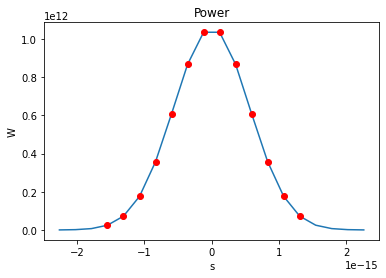

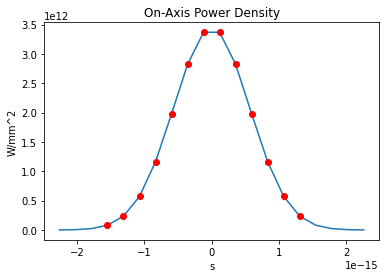

number of meaningful slices: 13
Pulse energy 0.0015 J
R-space
(400,) (400,)
FWHM in x = 5.187e-04 m.
FWHM in y = 5.187e-04 m.


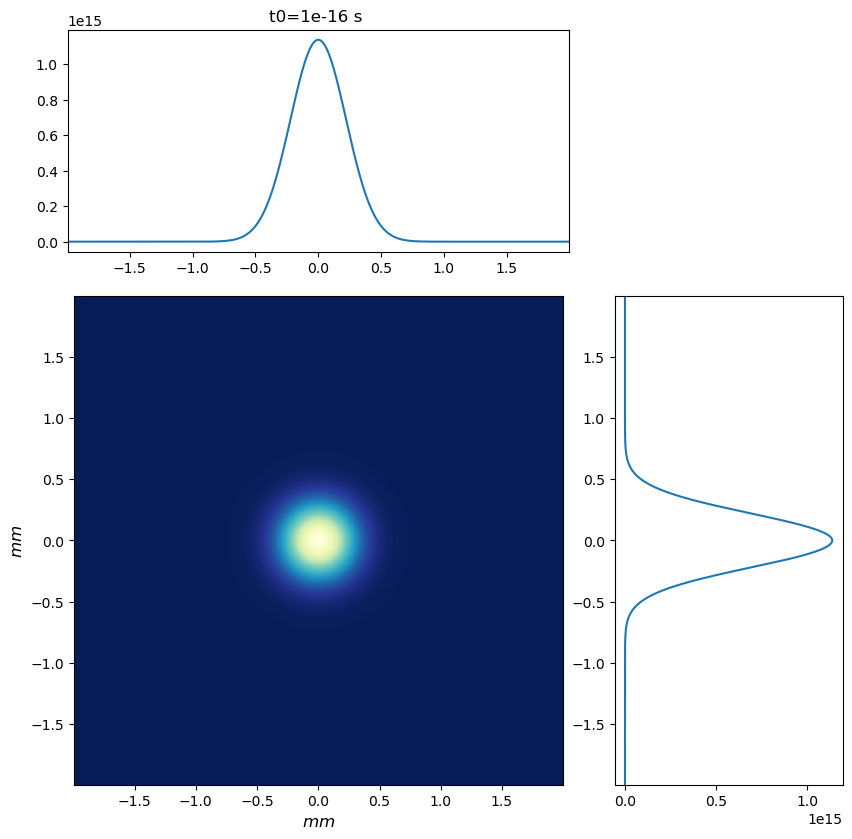

Q-space
{'fwhm_x': 2.000544926470588e-06, 'fwhm_y': 2.000544926470588e-06}
Q-space
(400,) (400,)


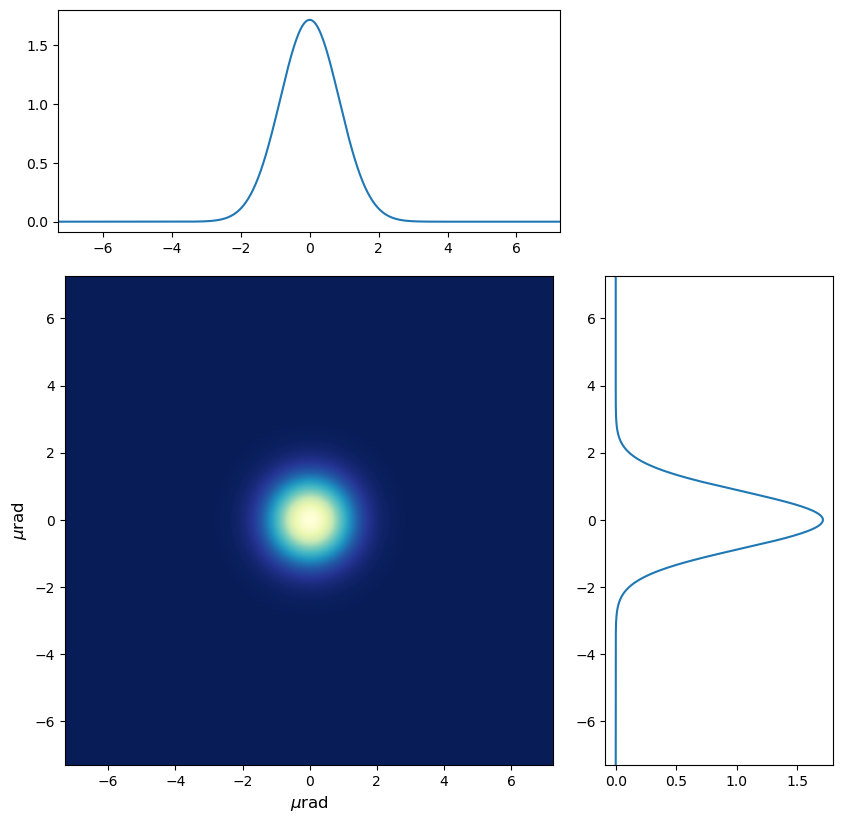

In [8]:
#input gaussian beam
print( 'dy {:.1f} um'.format((wf.params.Mesh.yMax-wf.params.Mesh.yMin)*1e6/(wf.params.Mesh.ny-1.)))
print( 'dx {:.1f} um'.format((wf.params.Mesh.xMax-wf.params.Mesh.xMin)*1e6/(wf.params.Mesh.nx-1.)))
plot_t_wf(wf)
look_at_q_space(wf)

In [10]:
''' beamline '''

#S1 beamline layout
### Geometry ###
src_to_hom1 = 257.8 # Distance source to HOM 1 [m]
src_to_hom2 = 267.8 # Distance source to HOM 2 [m]
src_to_crl = 887.8  # Distance source to CRL [m]
z0 = src_to_hom1

# Drift to focus aperture
z = 34.0

#define distances, angles, etc
#...
#Incidence angle at HOM
theta_om = 3.6e-3       # [rad]

om_mirror_length = 0.8 # [m]
om_clear_ap = om_mirror_length*theta_om

#define the beamline:
bl0 = Beamline()
zoom=1

# Define HOM1.
aperture_x_to_y_ratio = 1
hom1 = Aperture(shape='r',ap_or_ob='a',Dx=om_clear_ap,Dy=om_clear_ap/aperture_x_to_y_ratio)
bl0.append( hom1, Use_PP(semi_analytical_treatment=0, zoom=zoom, sampling=zoom) )

# Free space propagation from hom1 to hom2
hom1_to_hom2_drift = Drift(src_to_hom2 - src_to_hom1); z0 = z0+(src_to_hom2 - src_to_hom1)
bl0.append( hom1_to_hom2_drift, Use_PP(semi_analytical_treatment=0))


# Define HOM2.
zoom = 1.0
hom2 = Aperture('r','a', om_clear_ap, om_clear_ap/aperture_x_to_y_ratio)
bl0.append( hom2,  Use_PP(semi_analytical_treatment=0, zoom=zoom, sampling=zoom/0.75))

#drift to CRL aperture
hom2_to_crl_drift = Drift( src_to_crl - src_to_hom2 );z0 = z0+( src_to_crl - src_to_hom2 )
#bl0.append( hom2_to_crl_drift, Use_PP(semi_analytical_treatment=0))
bl0.append( hom2_to_crl_drift, Use_PP(semi_analytical_treatment=1))


# Define CRL
crl_focussing_plane = 3 # Both horizontal and vertical.
crl_delta = 4.7177e-06 # Refractive index decrement (n = 1- delta - i*beta)
crl_attenuation_length  = 6.3e-3    # Attenuation length [m], Henke data.
crl_shape = 1         # Parabolic lenses
crl_aperture = 5.0e-3 # [m]
crl_curvature_radius = 5.8e-3 # [m]
crl_number_of_lenses = 19
crl_wall_thickness = 8.0e-5 # Thickness
crl_center_horizontal_coordinate = 0.0
crl_center_vertical_coordinate = 0.0
crl_initial_photon_energy = 8.48e3 # [eV] ### OK ???
crl_final_photon_energy = 8.52e3 # [eV]   ### OK ???

crl = CRL( _foc_plane=crl_focussing_plane,
          _delta=crl_delta,
          _atten_len=crl_attenuation_length,
          _shape=crl_shape,
          _apert_h=crl_aperture,
          _apert_v=crl_aperture,
          _r_min=crl_curvature_radius,
          _n=crl_number_of_lenses,
          _wall_thick=crl_wall_thickness,
          _xc=crl_center_horizontal_coordinate,
          _yc=crl_center_vertical_coordinate,
          _void_cen_rad=None,
          _e_start=crl_initial_photon_energy,
          _e_fin=crl_final_photon_energy,
         )
zoom=0.6

bl0.append( crl, Use_PP(semi_analytical_treatment=1, zoom=zoom, sampling=zoom/0.1) )


crl_to_exp_drift = Drift( z ); z0 = z0+z
bl0.append( crl_to_exp_drift, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
#     bl0.append(Empty(),Use_PP(zoom=0.25, sampling=0.25))


Optical Element Setup: CRL Focal Length: 32.35296414510639 m


FWHM after CRLs:
{'fwhm_x': 1.7897682395761173e-05, 'fwhm_y': 1.779350912766013e-05}
FWHM at distance 921.8 m:
{'fwhm_x': 1.7897682395761173e-05, 'fwhm_y': 1.779350912766013e-05}


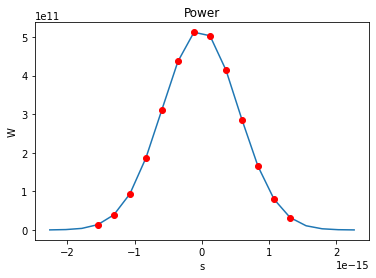

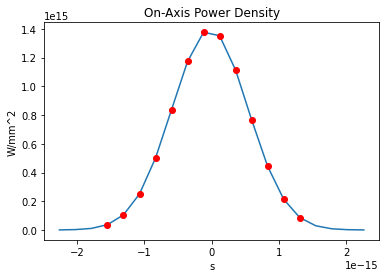

number of meaningful slices: 13
Pulse energy 0.00073 J
R-space
(1944,) (1944,)
FWHM in x = 1.790e-05 m.
FWHM in y = 1.779e-05 m.


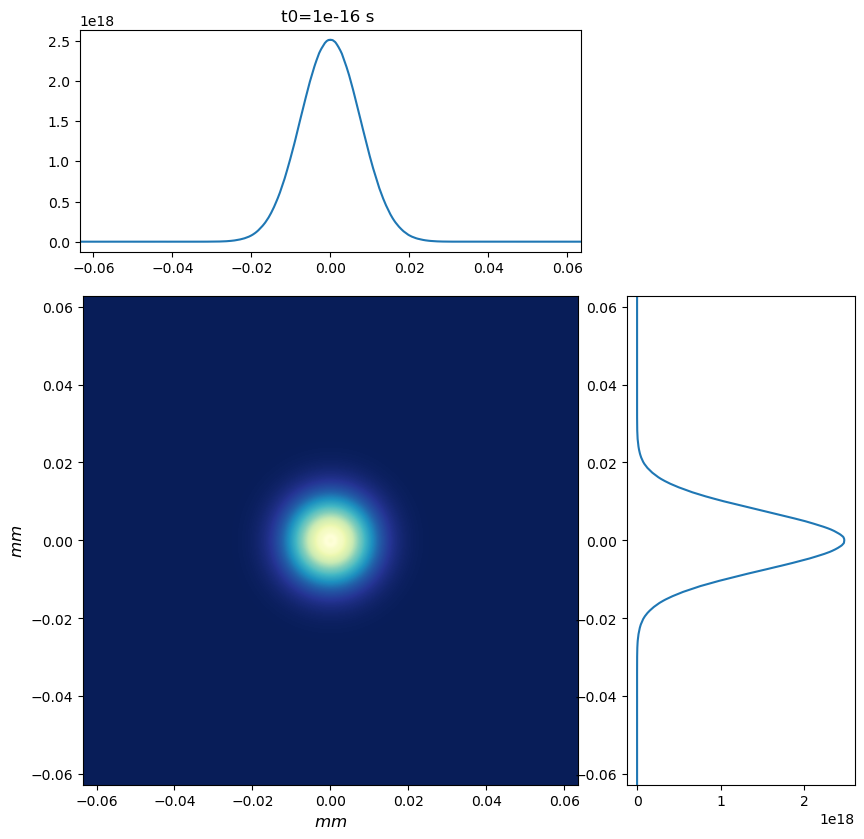

Q-space
{'fwhm_x': 4.2456580785283684e-05, 'fwhm_y': 4.3016862018036266e-05}
Q-space
(1944,) (1944,)


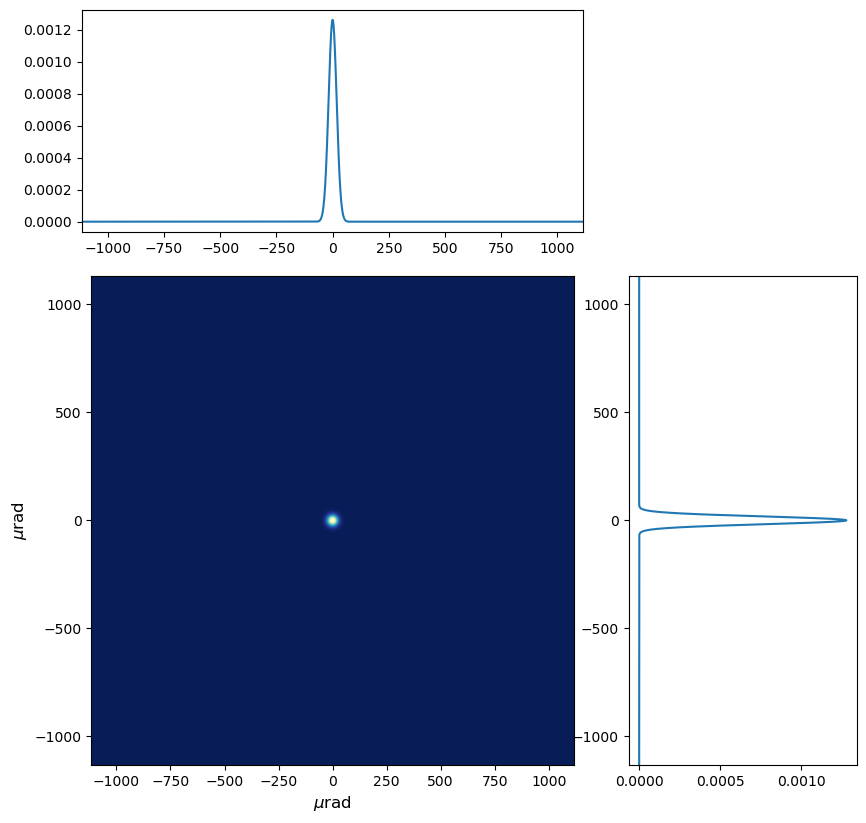

In [11]:
#propagated gaussian beam
srwl.SetRepresElecField(wf._srwl_wf, 'f') # <---- switch to frequency domain
bl0.propagate(wf)
srwl.SetRepresElecField(wf._srwl_wf, 't')
print('FWHM after CRLs:');print(calculate_fwhm(wf))
print('FWHM at distance {:.1f} m:'.format(wf.params.Mesh.zCoord));print(calculate_fwhm(wf))
plot_t_wf(wf)
look_at_q_space(wf)